In [51]:
!pip install imbalanced-learn

In [53]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
import sys 
from sklearn.metrics import *
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler

# Algorithmes
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

#Imbalanced learn
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, OneSidedSelection
from imblearn.pipeline import Pipeline, make_pipeline

#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
os.chdir(r"C:\Users\cornuch\Desktop\SISE\Fouille_donnees_massives\projet_fouille")  

In [3]:
df = pd.read_table("guillaume.txt", sep=";", header=0, decimal=",")

In [4]:
# Convertir DateTransaction en 2 colonnes : Date et Heure
DateTransaction_temp = df['DateTransaction'].str.split(' ', n=1)
df['Date'] = DateTransaction_temp.str[0]
df['Heure'] = DateTransaction_temp.str[1]
# Supprimer la colonne
df.drop(["DateTransaction"], axis = "columns", inplace = True)
df.head()

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,...,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure,Date
0,A013010004908126703060931,78643044,0,20.00,1,0,0,0,551,0.000000,...,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,07:32:14,2017-02-01
1,A013011306908024927155000,78643045,0,20.00,1,0,0,0,551,0.000000,...,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,07:43:37,2017-02-01
2,A013010002908283134592527,78643046,0,57.64,1,0,0,0,549,0.000000,...,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,07:47:38,2017-02-01
3,A011010002908105209831316,78643047,0,54.29,0,1,1,1,267,0.000000,...,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,07:48:48,2017-02-01
4,A013010041908000125652029,78643048,0,26.90,1,0,0,0,549,0.003769,...,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,08:13:27,2017-02-01


In [5]:
df.drop(['ZIBZIN','IDAvisAutorisationCheque','VerifianceCPT2','VerifianceCPT3','TauxImpNb_RB','DiffDateTr1','DiffDateTr2','CA3TRetMtt','Heure','CodeDecision'],axis = "columns", inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4646773 entries, 0 to 4646772
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   FlagImpaye      int64  
 1   Montant         float64
 2   VerifianceCPT1  int64  
 3   D2CB            int64  
 4   ScoringFP1      float64
 5   ScoringFP2      float64
 6   ScoringFP3      float64
 7   TauxImpNB_CPM   float64
 8   EcartNumCheq    int64  
 9   NbrMagasin3J    int64  
 10  DiffDateTr3     float64
 11  CA3TR           float64
 12  Date            object 
dtypes: float64(7), int64(5), object(1)
memory usage: 460.9+ MB


In [7]:
df_train=df.loc[df['Date']<='2017-08-31']
df_test=df.loc[df['Date']>='2017-09-01']

In [8]:
df_train0=df.drop(['Date'],axis = "columns", inplace = False)
df_test0=df.drop(['Date'],axis="columns",inplace=False)

In [9]:
# Définir la variable cible 
y_train = df_train0["FlagImpaye"]
y_test = df_test0["FlagImpaye"]

In [10]:
# Définir les variables explicatives 
X_train = df_train0.drop(["FlagImpaye"], axis = "columns")
X_test = df_test0.drop(["FlagImpaye"], axis = "columns")

In [14]:
X_train.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
1,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61
2,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
3,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00
4,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25


In [27]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [28]:
X_train_scale=mean_norm(X_train)

In [29]:
X_train_scale.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,-0.393578,-0.519039,1.074179,-0.081852,-0.209271,-0.282163,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
1,-0.393578,-0.519039,1.074179,-0.081852,-0.209271,-0.282163,0.810882,-0.042775,5.014647,-0.470527,0.037612
2,-0.024533,-0.519039,1.065117,-0.081852,-0.209271,-0.282163,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
3,-0.057378,1.742299,-0.212505,-0.081852,-0.209271,-0.282163,0.899215,-0.042780,-0.192611,-0.470527,-0.185443
4,-0.325927,-0.519039,1.065117,-0.081713,0.674504,-0.279713,0.810882,-0.042775,-0.192611,-0.470527,0.650042


In [17]:
def perte(Montant):
    if Montant<=20:
        Montant=Montant*0
    elif 20<Montant<=50:
        Montant=0.2*Montant
    elif 50<Montant<=100:
        Montant=0.3*Montant
    elif 100<Montant<=200:
        Montant=0.5*Montant
    elif Montant>200:
        Montant=0.8*Montant
    return(Montant)

In [18]:
def Calcul_Marge(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable Marge
    # Création d'une colonne Marge égale au Montant
    dfmerge["Marge"] = dfmerge["Montant"]
    #Calcul du gain ou de la perte selon la différence entre réel et prédiction
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "Marge"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "Marge"] = 0.7 * 0.05 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "Marge"] = dfmerge["Montant"].apply(lambda x: -perte(x))
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 0)), "Marge"] = 0.05 * dfmerge["Montant"]
    
    # Calcul du Marge_totale
    Marge_totale = dfmerge["Marge"].sum()
    
    return Marge_totale

In [30]:
# Création de la fonction de performance d'un modèle sur les données de test

def performances(modele, X_test, y_test, scale):
    
    X_test_ = X_test
    
    print("-------------------------------------------------------")
    # Importation du modèle 
    #fichier = open(modele, "rb")
    #modele = pickle.load(fichier)
    #fichier.close()
    
    if scale == True:
        X_test = mean_norm(X_test)
        
    # Affichage du modèle 
    print('Modèle :\n', modele)
    print("-------------------------------------------------------")
    # Prédiction
    y_pred = modele.predict(X_test)
    # Prédiction des scores
    y_score = modele.predict_proba(X_test)
    
    # Estimateurs, matrice de confusion et AUC
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
   
    print('F1_score :\n', f1)
    print("-------------------------------------------------------")
    print('Estimateurs :\n', cr)
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm)
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc)
    print("-------------------------------------------------------")
    
    #Calcul de la Marge
    Marge_totale = Calcul_Marge(Montant = X_test_["Montant"], yReel = y_test, yPred = y_pred)
    print("Marge = " + str(round(Marge_totale, 2)) + " euros")
    
    print("-------------------------------------------------------")
    
    # Courbe ROC
    skplt.metrics.plot_roc(y_test, y_score, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(y_test, y_score, classes_to_plot = 1, plot_micro = False)

    #return y_score,Marge_totale,auc,cr,cm

In [ ]:
def experience(sampler,classifier,X_train,y_train,X_test,y_test):
    X_res, y_res = sampler.fit_resample(X_train_scale, y_train)
    clf = classifieur.fit(X_res, y_res)
    performances(clf, X_test, y_test,scale=True)

In [20]:
sampler=SMOTE(random_state=0)
X_res, y_res = sampler.fit_resample(X_train_scale, y_train)

In [21]:
clf = LogisticRegression(solver='saga',random_state=0).fit(X_res, y_res)

-------------------------------------------------------
Modèle :
 LogisticRegression(random_state=0, solver='saga')
-------------------------------------------------------
F1_score :
 0.029950350668497706
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.73      0.84   4616778
           1       0.02      0.65      0.03     29995

    accuracy                           0.73   4646773
   macro avg       0.51      0.69      0.44   4646773
weighted avg       0.99      0.73      0.84   4646773

-------------------------------------------------------
Matrice de confusion :
 [[3359974 1256804]
 [  10432   19563]]
-------------------------------------------------------
Auc Score :
 0.6899916764748104
-------------------------------------------------------
Marge = 12062534.71 euros
-------------------------------------------------------


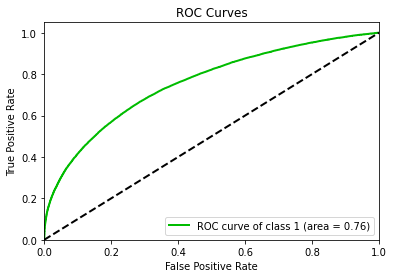

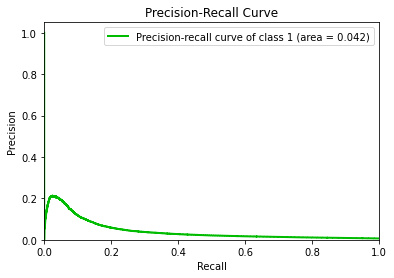

In [31]:
performances(clf, X_test, y_test,scale=True)

**Modifier le seuil d'affectation**

In [33]:
from numpy import arange
from numpy import argmax

In [34]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

In [38]:
def modif_seuil(classifier,X_test_scale,y_test):
    # predict probabilities
    yhat = classifier.predict_proba(X_test_scale)
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0.1, 1, 0.1)
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = argmax(scores)
    s=('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return s

In [39]:
modif_seuil(clf,mean_norm(X_test),y_test)

'Threshold=0.900, F-Score=0.10882'

-------------------------------------------------------
Modèle :
 LogisticRegression(random_state=0, solver='saga')
-------------------------------------------------------
F1_score :
 0.028957004897883745
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.71      0.83   4616778
           1       0.01      0.67      0.03     29995

    accuracy                           0.71   4646773
   macro avg       0.51      0.69      0.43   4646773
weighted avg       0.99      0.71      0.82   4646773

-------------------------------------------------------
Matrice de confusion :
 [[3281739 1335039]
 [   9941   20054]]
-------------------------------------------------------
Auc Score :
 0.689703473559672
-------------------------------------------------------
Marge = 11999926.51 euros
-------------------------------------------------------


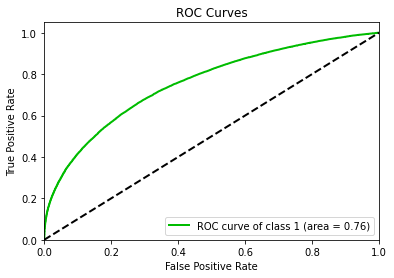

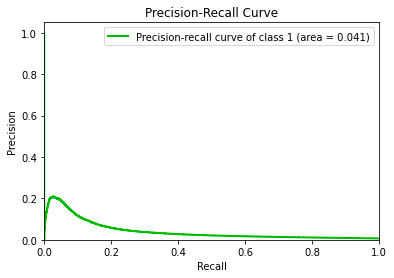

In [41]:
sampler1=SMOTEENN(random_state=0)
X_res1, y_res1 = sampler1.fit_resample(X_train_scale, y_train)
clf1 = LogisticRegression(solver='saga',random_state=0).fit(X_res1, y_res1)
performances(clf1, X_test, y_test,scale=True)

-------------------------------------------------------
Modèle :
 LogisticRegression(random_state=0, solver='saga')
-------------------------------------------------------
F1_score :
 0.029365106900652485
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.72      0.83   4616778
           1       0.02      0.66      0.03     29995

    accuracy                           0.72   4646773
   macro avg       0.51      0.69      0.43   4646773
weighted avg       0.99      0.72      0.83   4646773

-------------------------------------------------------
Matrice de confusion :
 [[3311994 1304784]
 [  10105   19890]]
-------------------------------------------------------
Auc Score :
 0.6902463203785015
-------------------------------------------------------
Marge = 12032083.94 euros
-------------------------------------------------------


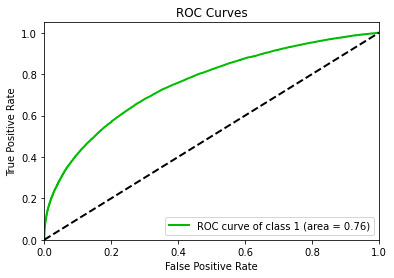

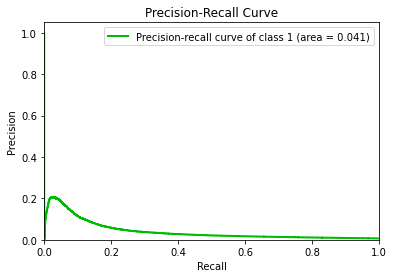

In [42]:
sampler2=ADASYN(random_state=0)
X_res2, y_res2 = sampler2.fit_resample(X_train_scale, y_train)
clf2 = LogisticRegression(solver='saga',random_state=0).fit(X_res2, y_res2)
performances(clf2, X_test, y_test,scale=True)

In [44]:
modif_seuil(clf2,mean_norm(X_test),y_test)

'Threshold=0.900, F-Score=0.10699'

In [54]:
start = time.time()

In [ ]:
sampler3=OneSidedSelection(random_state=0)
X_res3, y_res3 = sampler3.fit_resample(X_train_scale, y_train)
clf3 = LogisticRegression(solver='saga',random_state=0).fit(X_res3, y_res3)
performances(clf3, X_test, y_test,scale=True)

In [ ]:
end = time.time()
elapsed = end - start

print(f'Temps d\'exécution : {elapsed:.2}ms')

In [ ]:
sampler4=SMOTETomek(random_state=0)
classifier4=LogisticRegression(solver='saga',random_state=0)
experience(sampler4,classifier4,X_train_sclae,y_train,X_test,y_test)